In [124]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px


In [125]:
regions = ["ENG", "SCT", "NIR", "WLS"]
temp = [["ENG", "SCT", "NIR", "WLS"], ["England", "Scotland", "Northern Ireland", "Wales"]]
region_to_name = pd.DataFrame(temp).T
region_to_name.columns = ["ABR", "NAME_1"]


In [126]:
places = ["England", 12601,
"Northern Ireland", 35.892,
"Scotland", 1263,
"Wales", 61.14,
"Total", 1482.99]

p = [places[x] for x in range(0, len(places)-2, 2)]
x = [places[x] for x in range(1, len(places)-1, 2)]
pop = [55977000, 1876000, 5437000, 3127000]
compensation1 = [79860, 78296, 77779, 82669]
providers = pd.DataFrame([x,p, pop, compensation1]).T
providers.columns = ["Providers", "NAME_1", "Population", "Compensation1"]
providers["Compensation1"] = providers["Compensation1"].astype("float")

In [127]:
def all_conditions(month, years):
    kw_list = ["cataract", "diabetic retinopathy", "macular degeneration", "uveitis"]
    all_data = pull_all_states("glaucoma", month, years)
    for x in kw_list:
        all_data = pd.concat([all_data, pull_all_states(x, month, years)])
    return all_data

In [128]:
def pull_all_states(condition, month, years):
    all_data = covid_total_pull(condition, month, years, "ENG")
    for r in regions:
        if r != "ENG":
            data_next = covid_total_pull(condition, month, years, r)
            if data_next is not None:
                all_data[r] = data_next[r]
            else:
                all_data[r] = 0
    return all_data

In [129]:
def covid_total_pull(condition, month, years, r):
    years_all = [x for x in range(years[0], years[-1]+1)]
    months = ["0"+str(x) for x in range(1,10)] + [str(x) for x in range(10,13)]
    dates = [str(years_all[0])+"-"+months[y]+"-01" for y in range(month-1, 12)]
    if len(years_all) >=2:
        dates += [str(years_all[-1])+"-"+months[y]+"-01" for y in range(0,month)]
    if len(years_all) >2:
        for x in range(years_all[1], years_all[-1]):
            dates += [str(x)+"-"+months[y]+"-01" for y in range(0,12)]
    dates = sorted(dates)
    
    df = pd.read_csv("UK/"+condition+"_"+r+".csv")
    try:
        df = df.drop("isPartial", axis = 1)
    except:
        return None
    df = df[df["date"].isin(dates)].mean()
    df = pd.DataFrame(df, columns = [r])
    return(df)


In [130]:
state_to_state = all_conditions(10, [2017, 2018]).mean()
state_to_state = pd.DataFrame(state_to_state)
state_to_state.reset_index(inplace=True)
state_to_state.columns = ["ABR", "Interest_18"]
state_to_state = state_to_state.merge(region_to_name, on="ABR")
states = geopandas.read_file('GBR_adm/GBR_adm1.shp')
states = states.merge(state_to_state, on="NAME_1")
states = states.merge(providers, on="NAME_1")
states["Rate_100k_18"] = states["Providers"]/states["Population"] * 100000
states["Rate_100k_18"] = states["Rate_100k_18"].astype('float64')
states["Need_18"] = states["Interest_18"]/states["Rate_100k_18"]


C:\Users\aidan\AppData\Local\Temp\ipykernel_24412\2881226503.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df[df["date"].isin(dates)].mean()
C:\Users\aidan\AppData\Local\Temp\ipykernel_24412\2881226503.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df[df["date"].isin(dates)].mean()
C:\Users\aidan\AppData\Local\Temp\ipykernel_24412\2881226503.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df[df["date"].isin(dates)].mean()
C:\Users\aidan\AppData\Local\Te

In [131]:
states

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,ABR,Interest_18,Providers,Population,Compensation1,Rate_100k_18,Need_18
0,242,GBR,United Kingdom,1,England,Home Nation|Constituent Country,Kingdom,None,None,"MULTIPOLYGON (((-6.38792 49.86875, -6.38792 49...",ENG,56.169231,12601,55977000,79860.0,22.511031,2.495187
1,242,GBR,United Kingdom,2,Northern Ireland,Home Nation|Constituent Country,Province,None,Ulster,"MULTIPOLYGON (((-6.09417 54.05153, -6.09417 54...",NIR,13.646154,35.892,1876000,78296.0,1.913220,7.132560
2,242,GBR,United Kingdom,3,Scotland,Home Nation|Constituent Country,Kingdom,None,Alba,"MULTIPOLYGON (((-4.70083 54.66570, -4.70083 54...",SCT,38.861538,1263,5437000,77779.0,23.229722,1.672923
3,242,GBR,United Kingdom,4,Wales,Home Nation|Constituent Country,Principality,None,Cymru,"MULTIPOLYGON (((-3.10472 51.34153, -3.10472 51...",WLS,15.138462,61.14,3127000,82669.0,1.955229,7.742553


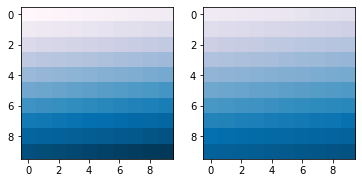

In [132]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)
cmap = plt.get_cmap('PuBu')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [133]:
x = states["Need_18"]
y = states["Compensation1"]

In [134]:
x

0    2.495187
1    7.132560
2    1.672923
3    7.742553
Name: Need_18, dtype: float64

Text(9, 77000, '$y=380.077\\;x+77841.529$\n$R^2 = 0.291$')

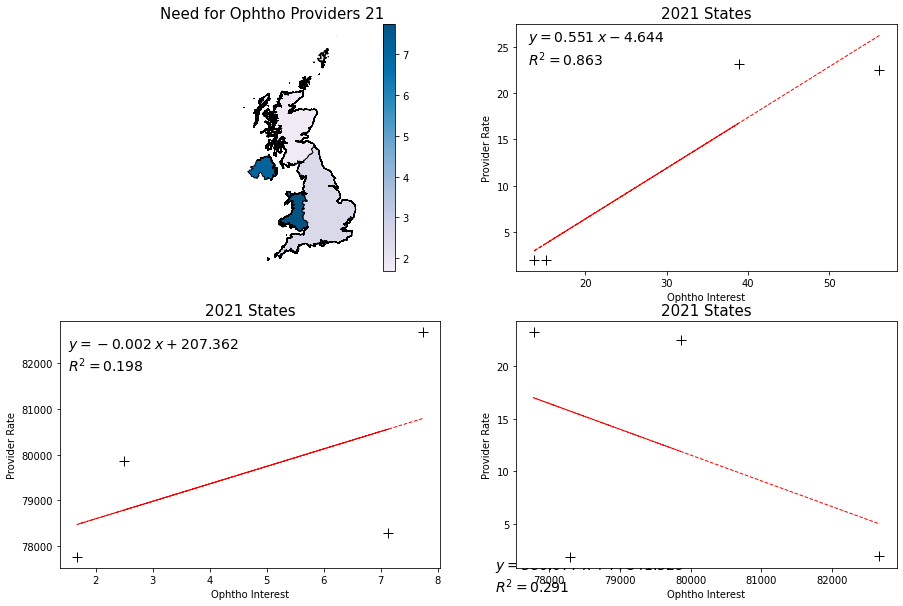

In [176]:
# Geo Map by State
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 21', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')

#Scatter by State
ax4.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax4.set_xlabel("Ophtho Interest")
ax4.set_ylabel("Provider Rate")
x = states["Compensation1"]
y = states["Rate_100k_18"]

ax4.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax4.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax4.text(71200, 19.5, text,
     fontsize=14)


#Scatter by State
ax2.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax2.set_xlabel("Ophtho Interest")
ax2.set_ylabel("Provider Rate")
x = states["Need_18"]
y = states["Compensation1"]

ax2.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax2.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax2.text(9, 77000, text,
     fontsize=14)


# fig.savefig('Figures/2021.png')

Text(13, 27, '$y=0.551\\;x-4.644$\n$R^2 = 0.863$')

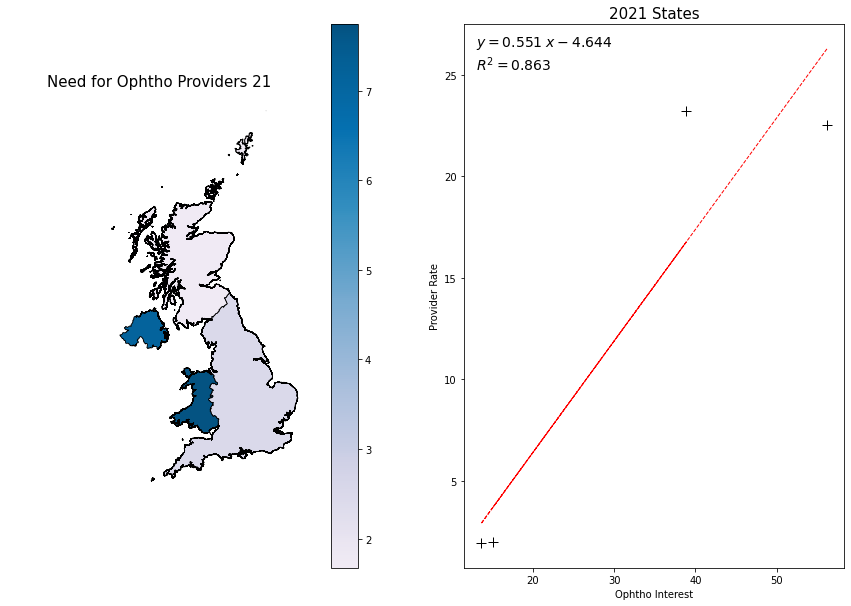

In [136]:
# Geo Map by State
fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(15, 10))
ax1.axis('off')
ax1.set_title('Need for Ophtho Providers 21', fontdict={'fontsize': '15', 'fontweight' : '3'})
states.plot(column='Need_18',
          cmap=new_cmap,
          linewidth=0.9,
            ax=ax1,
            edgecolor='0',
            legend=True)

#Scatter by State
ax3.set_title('2021 States', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax3.set_xlabel("Ophtho Interest")
ax3.set_ylabel("Provider Rate")
x = states["Interest_18"]
y = states["Rate_100k_18"]

ax3.plot(x,y,"+", 
         ms=10, 
         mec="k",)

z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

ax3.plot(x, y_hat, 
         "r--",
         lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
ax3.text(13, 27, text,
     fontsize=14, verticalalignment='top')


# fig.savefig('Figures/2021.png')